In [1]:
import json
from random import shuffle
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
import nltk
from nltk import word_tokenize
from nltk.classify import SklearnClassifier
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import Counter
import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn import decomposition, ensemble
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from nltk.stem import WordNetLemmatizer 
import spacy
from spacy import displacy
from collections import Counter
from pprint import pprint
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [5]:
top_char=20

In [6]:
# Read JSON scripts into dataframe
df=pd.read_json('data/dialogues-combined.json')
df.columns=['script_number','scene','character','dialogue','attributes','char_groups']
df['scene']=df['scene'].str.split('|')

In [7]:
# Select most frequent characters
x=df.character.value_counts().head(top_char).keys()
df=df.loc[df['character'].isin(x)]
df=df.reset_index(drop=True)

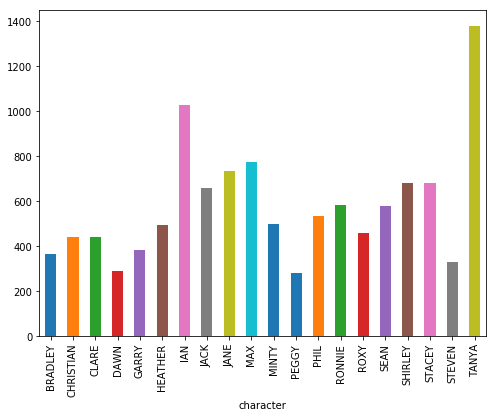

In [8]:
# Plot count of dialogues
fig = plt.figure(figsize=(8,6))
df.groupby('character').dialogue.count().plot.bar(ylim=0)
plt.show()

In [9]:
# Add Gender Heuristic to the data
gender_df = pd.read_csv('data/gender.csv',na_filter=False)
gender_dict=dict(zip(gender_df.name, gender_df.gender))
df['gender']=df['character'].apply(lambda x: 'unknown' if gender_dict.get(x,'') =='' else  gender_dict[x])

In [10]:
# Label encoding
encoder = preprocessing.LabelEncoder()
char = encoder.fit_transform(df['character'])
#df = df.drop('character', axis=1)
df['category_id']=char
labels = df.category_id

#create an ordered mapping between character and category_id
category_df = df[['character', 'category_id']].drop_duplicates().sort_values('category_id')

In [11]:
# preview dataset
df.head()

,script_number,scene,character,dialogue,attributes,char_groups,gender,category_id
0,1350,"[DESERTED CAR PARK, EXT, NIGHT]",SHIRLEY,"Look at ya, not a mark on ya. And you think yo...",[],"[KEVIN, SHIRLEY]",female,16
1,1350,"[R&R, INT, NIGHT]",JACK,Oi. Where have you been? Huh? What were the te...,[],"[JACK, RONNIE]",male,7
2,1350,"[R&R, INT, NIGHT]",RONNIE,Nothing. Nothing. I'll be with you in two minu...,[],"[JACK, RONNIE]",female,13
3,1350,"[R&R, INT, NIGHT]",JACK,Well I've got mates here I wanted to have a ch...,[],"[JACK, RONNIE]",male,7
4,1350,"[R&R, INT, NIGHT]",RONNIE,Alright. Two minutes.,[],"[JACK, RONNIE]",female,13


# Test Data

In [12]:
scene=[]
dialogue=""" I’m… I'm sick, I'm sick Max ... I need to get better, I need to... I need to recover and you won't let me... will ya? I loved you with all my heart ... and now ... even now ... there’s still something there. How disgusting is that? To still have feelings like that. But not you though eh? Not you. The only person you love is yourself ... is Max Branning ... king of the world ain't he? That's what you tell yourself. I know the truth, inside you‘re just, you're just a frightened, sad, lonely little boy, frightened kid who’s dad didn’t love him enough. And it’s all... it's all so pathetic. """
attributes=[]
char_groups=[]
gender='unknown'

test_df=pd.DataFrame.from_dict([{'script_number': None,'scene': scene,'character': None,'dialogue':dialogue,'attributes':attributes,'char_groups':char_groups,'gender':gender,'category_id':None}])
df=df.append(test_df)
test_df


,attributes,category_id,char_groups,character,dialogue,gender,scene,script_number
0,[],None,[],None,"I’m… I'm sick, I'm sick Max ... I need to get...",unknown,[],None


# Feature Engineering

#### Text preprocessing Function

In [13]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

#### Non-Textual Features

In [14]:
# Method to parse attributes into dictionary
def parseAttribures(attr):
    if attr is None:
        return None
    else:
        return dict((x,attr.count(x)) for x in set(attr))


#Scene Details as features
def f_scene_func(df):
    f_scene=DictVectorizer().fit_transform(df['scene'].apply(parseAttribures))
    return f_scene

# Script's parenthetical attributes as features
def f_attributes_func(df):
    f_attributes=DictVectorizer().fit_transform(df['attributes'].apply(parseAttribures)) 
    max_abs_scaler = preprocessing.MaxAbsScaler()
    f_attributes_scaled = max_abs_scaler.fit_transform(f_attributes)   # parenthetical attributes as features  - SCALED
    return f_attributes_scaled

# Top 100 Character groups as features
def f_char_groups_func(df):
    top_char_groups=list(df['char_groups'].apply('|'.join).value_counts().head(100).keys())
    f_char_groups=DictVectorizer().fit_transform(df['char_groups'].apply('|'.join).apply(lambda x: x  if x  in top_char_groups else 'UNKNOWN').apply(lambda x:[x]).apply(parseAttribures))
    return f_char_groups

# Gender as a Feature
def f_gender_func(df):
    f_gender=DictVectorizer().fit_transform(df['gender'].apply(lambda x:[x]).apply(parseAttribures))
    return f_gender


#### Text Metadata features

In [15]:
def extractMeta(x):
    return {'count_chars': len(x),
            'count_whitespace': x.count(" "),
            'count_dots': x.count(".")-3*(x.count("...")),
            'count_cdots': x.count("..."),
            'count_excl': x.count("!"),
            'count_ques': x.count("?"),
            'count_num': len(re.findall("\d", x)),
            'count_upper': len(re.findall("[A-Z]", x)),
            'count_words': len(x) / (x.count(" ") + 1),
            'count_sent': x.count(" ") / (x.count(".") + 1)           
           }

def f_meta_func(df):
    f_meta=DictVectorizer().fit_transform(df['dialogue'].apply(extractMeta))
    max_abs_scaler = preprocessing.MaxAbsScaler()
    f_meta_scaled = max_abs_scaler.fit_transform(f_meta)  # Metadata features scaled
    return f_meta_scaled

#### N-gram counts and frequencies

In [16]:
#Count Vectors
def f_count_func(df):
    count_vect = CountVectorizer(analyzer='word', stop_words='english',token_pattern=r'\w{1,}')
    f_count=count_vect.fit_transform(df['dialogue'])
    return f_count


#TF-IDF unigram
def f_tfidf_func(df):
    tfidf_vect = TfidfVectorizer(analyzer='word',token_pattern=r"\b\w[\w']+\b", tokenizer=LemmaTokenizer(),max_features=5000)
    f_tfidf=tfidf_vect.fit_transform(df['dialogue'])
    return f_tfidf

#TF-IDF n-gram
def f_tfidf_ngram_func(df):
    tfidf_ngram_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    f_tfidf_ngram=tfidf_ngram_vect.fit_transform(df['dialogue'])
    return f_tfidf_ngram

#TF-IDF char n-gram
def f_tfidf_ngram_chars_func(df):
    tfidf_ngram_chars_vect = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    f_tfidf_ngram_chars=tfidf_ngram_chars_vect.fit_transform(df['dialogue'])


#### POS Tags

In [17]:
from nltk.tag import CRFTagger
import pycrfsuite


def f_pos_tags_func(df):
    tokenizer = RegexpTokenizer(r'\w+')
    TAGGER_PATH = "data/crfpostagger"   # pre-trained POS-tagger 
    tagger = CRFTagger()  
    tagger.set_model_file(TAGGER_PATH)

    pos_tags=tagger.tag_sents([word.lower() for word in s] for s in df['dialogue'].apply(tokenizer.tokenize))
    pos_tags_str = []
    for word in pos_tags:
        pos_tags_con=[w[0]+'_'+w[1] for w in word]
        pos_tags_str.append(' '.join(pos_tags_con))
    tfidf_pos = TfidfVectorizer(lowercase=False,max_features=5000)
    f_pos_tags=tfidf_pos.fit_transform(pos_tags_str)
    return f_pos_tags

#### POS Tags a metadata features

In [18]:
####### count of each POS type 
def check_pos_tag(x, flag):
    cnt = 0
    try:
        for tup in x:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


def extractPOS(x):
    count_noun=check_pos_tag(x,'noun')
    count_verb=check_pos_tag(x,'verb')
    count_adj=check_pos_tag(x,'adj')
    count_adv=check_pos_tag(x,'adv')
    count_pron=check_pos_tag(x,'pron')
    count_sum=count_noun+count_verb+count_adj+count_adv+count_pron+1
    return {'count_noun': count_noun/count_sum,
            'count_verb': count_verb/count_sum,
            'count_adj': count_adj/count_sum,
            'count_adv': count_adv/count_sum,
            'count_pron': count_pron/count_sum,
           }


def f_pos_count_func(df):
    tokenizer = RegexpTokenizer(r'\w+')
    TAGGER_PATH = "data/crfpostagger"   # pre-trained POS-tagger 
    tagger = CRFTagger()  
    tagger.set_model_file(TAGGER_PATH)
    pos_family = {
        'noun' : ['NN','NNS','NNP','NNPS'],
        'pron' : ['PRP','PRP$','WP','WP$'],
        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
        'adj' :  ['JJ','JJR','JJS'],
        'adv' : ['RB','RBR','RBS','WRB']
    }
    f_pos_count=DictVectorizer().fit_transform(df['dialogue'].apply(tokenizer.tokenize).apply(lambda x: [word.lower() for word in x]).apply(tagger.tag).apply(extractPOS))
    return f_pos_count


#### Topic Modelling

In [19]:
# train a LDA Model

#tm_vect = TfidfVectorizer(analyzer='word',token_pattern=r"\b\w[\w']+\b",stop_words='english', max_features=5000)

def f_topics_func(df):
    tm_vect = CountVectorizer(analyzer='word', stop_words='english',token_pattern=r"\b\w[\w']+\b")
    f_tm=tm_vect.fit_transform(df['dialogue'])
    lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
    f_topics = lda_model.fit_transform(f_tm)
    return f_topics

#### Named Entity Recognition

In [20]:
def f_ner_func(df):
    spacy_nlp = spacy.load('en')
    doc = df['dialogue'].apply(spacy_nlp).apply(lambda x : [X.label_ for X in x.ents])
    def getCountNER(attr):
        return dict((x,attr.count(x)) for x in set(attr))
    f_ner=DictVectorizer().fit_transform(doc.apply(getCountNER))  # Number of each type of named entity -> as a feature
    return f_ner


#### Sentiment

In [21]:
def f_sent_func(df):
    sia = SIA()
    sentiment= df['dialogue'].apply(sia.polarity_scores)
    f_sent=DictVectorizer().fit_transform(df['dialogue'].apply(sia.polarity_scores)) #Sentiment polarity score as feature
    min_max_scaler = preprocessing.MinMaxScaler()
    f_sent_scaled = min_max_scaler.fit_transform(f_sent.toarray()) # Sentiment features scaled
    return f_sent_scaled


# Text Classification

In [22]:
# Define classifiers to be evaluated

# Define feature selector
feature_selector=SelectKBest(chi2, k=1000)

#Create pipelines for each classifier type
svm_pipeline = Pipeline([('chi2', feature_selector),('svm', LinearSVC())])
nb_pipeline = Pipeline([('chi2', feature_selector),('nb', MultinomialNB())])
lr_pipeline = Pipeline([('chi2', feature_selector),('lr', LogisticRegression())])

# Create classifier list
models = [
    OneVsRestClassifier(svm_pipeline),
    OneVsRestClassifier(nb_pipeline),
    OneVsRestClassifier(lr_pipeline)
]
model_names=['SVM', 'Naive-Bayes','Max-Entropy']

In [23]:
# cross validation function
def cross_validation(features,labels, fold):
    cv_df = pd.DataFrame(index=range(fold * len(models)))
    entries = []
    for model,model_name in zip(models,model_names):
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=fold)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    return cv_df

### 1. Only Textual Features

In [24]:
# Combining Features
features=sparse.hstack([f_tfidf_func(df),f_topics_func(df),f_pos_tags_func(df),f_ner_func(df),f_meta_func(df),f_pos_count_func(df),f_sent_func(df)])


In [25]:
# Split data into train and test
X_train=features.tocsr()[:-1]
X_test=features.tocsr()[-1]
y_train=labels

In [26]:
# Training and Testing
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
category_df.set_index('category_id').iloc[y_pred]

,character
category_id,
19,TANYA


### 2. Textual Features with Scene details and Parenthetical Attributes

In [27]:
# Combining Features
features=sparse.hstack([features,f_scene_func(df),f_attributes_func(df)])


In [28]:
# Split data into train and test
X_train=features.tocsr()[:-1]
X_test=features.tocsr()[-1]
y_train=labels

In [29]:
# Training and Testing
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
category_df.set_index('category_id').iloc[y_pred]

,character
category_id,
17,STACEY


### 3. Textual Features with Scene details,  Parenthetical Attributes and character groups

In [30]:
# Combining Features
features=sparse.hstack([features,f_char_groups_func(df)])


In [31]:
# Split data into train and test
X_train=features.tocsr()[:-1]
X_test=features.tocsr()[-1]
y_train=labels

In [32]:
# Training and Testing
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
category_df.set_index('category_id').iloc[y_pred]

,character
category_id,
3,DAWN


### 4. Textual Features with Scene details,  Parenthetical Attributes and character groups and gender

In [33]:
# Combining Features
features=sparse.hstack([features, f_gender_func(df)])


In [34]:
# Split data into train and test
X_train=features.tocsr()[:-1]
X_test=features.tocsr()[-1]
y_train=labels

In [35]:
# Training and Testing
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
category_df.set_index('category_id').iloc[y_pred]

,character
category_id,
3,DAWN
